# Atelier 3 : Clustering - Machine Learning

Université Abdelmalek Essaâdi · FST Tanger · Département GI

Cycle Ingénieur LSI – S3 – 2025/2026 · Encadrant : Pr. EL AACHAK LOTFI

**Dataset** : Credit Card Dataset (Kaggle)

**Objectif** : Pratiquer les concepts du clustering en utilisant différents algorithmes (K-Means, Fuzzy C-Means, DBSCAN, EM, SOM, Hierarchical Clustering) avec réduction de dimensionnalité (PCA, t-SNE).

In [1]:
# =============================================================================
# Import des bibliothèques nécessaires
# =============================================================================
import os
import pathlib
import warnings
from typing import Dict, List, Tuple

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Sklearn - Preprocessing & Decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Sklearn - Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Hierarchical clustering - dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Fuzzy C-Means
import skfuzzy as fuzz

# Self-Organizing Maps
from minisom import MiniSom

# Configuration
plt.style.use("seaborn-v0_8")
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Chemins du projet
PROJECT_ROOT = pathlib.Path("..").resolve()
DATA_PATH = PROJECT_ROOT / "dataset" / "CC GENERAL.csv"
FIG_PATH = PROJECT_ROOT / "figures"
MODEL_PATH = PROJECT_ROOT / "models"
FIG_PATH.mkdir(parents=True, exist_ok=True)
MODEL_PATH.mkdir(parents=True, exist_ok=True)

print("Bibliothèques importées avec succès !")

Bibliothèques importées avec succès !


## Partie 1 : Data Visualisation

### 1.1 Chargement et exploration des données

In [2]:
# =============================================================================
# Chargement du dataset
# =============================================================================
def load_credit_card_data(path: pathlib.Path) -> pd.DataFrame:
    """Charge le dataset Credit Card depuis le fichier CSV."""
    if not path.exists():
        raise FileNotFoundError(
            f"Fichier non trouvé: {path}\n"
            "Téléchargez le dataset depuis: https://www.kaggle.com/arjunbhasin2013/ccdata\n"
            "Et placez 'CC GENERAL.csv' dans le dossier dataset/"
        )
    df = pd.read_csv(path)
    return df

# Charger les données
df = load_credit_card_data(DATA_PATH)

# Aperçu des données
print("=" * 60)
print("APERÇU DU DATASET")
print("=" * 60)
print(f"\nDimensions: {df.shape[0]} lignes × {df.shape[1]} colonnes")
print(f"\nColonnes: {list(df.columns)}")
df.head(10)

APERÇU DU DATASET

Dimensions: 8950 lignes × 18 colonnes

Colonnes: ['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.000000,12
6,C10007,627.260806,1.000000,7091.01,6402.63,688.38,0.000000,1.000000,1.000000,1.000000,0.000000,0,64,13500.0,6354.314328,198.065894,1.000000,12
7,C10008,1823.652743,1.000000,436.20,0.00,436.20,0.000000,1.000000,0.000000,1.000000,0.000000,0,12,2300.0,679.065082,532.033990,0.000000,12
8,C10009,1014.926473,1.000000,861.49,661.49,200.00,0.000000,0.333333,0.083333,0.250000,0.000000,0,5,7000.0,688.278568,311.963409,0.000000,12
9,C10010,152.225975,0.545455,1281.60,1281.60,0.00,0.000000,0.166667,0.166667,0.000000,0.000000,0,3,11000.0,1164.770591,100.302262,0.000000,12


In [3]:
# Informations sur les types de données
print("\n" + "=" * 60)
print("TYPES DE DONNÉES")
print("=" * 60)
print(df.dtypes)

# Valeurs manquantes
print("\n" + "=" * 60)
print("VALEURS MANQUANTES")
print("=" * 60)
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Valeurs manquantes': missing,
    'Pourcentage (%)': missing_pct
})
print(missing_df[missing_df['Valeurs manquantes'] > 0])


TYPES DE DONNÉES
CUST_ID                              object
BALANCE                             float64
BALANCE_FREQUENCY                   float64
PURCHASES                           float64
ONEOFF_PURCHASES                    float64
INSTALLMENTS_PURCHASES              float64
CASH_ADVANCE                        float64
PURCHASES_FREQUENCY                 float64
ONEOFF_PURCHASES_FREQUENCY          float64
PURCHASES_INSTALLMENTS_FREQUENCY    float64
CASH_ADVANCE_FREQUENCY              float64
CASH_ADVANCE_TRX                      int64
PURCHASES_TRX                         int64
CREDIT_LIMIT                        float64
PAYMENTS                            float64
MINIMUM_PAYMENTS                    float64
PRC_FULL_PAYMENT                    float64
TENURE                                int64
dtype: object

VALEURS MANQUANTES
                  Valeurs manquantes  Pourcentage (%)
CREDIT_LIMIT                       1             0.01
MINIMUM_PAYMENTS                 313            

In [4]:
# =============================================================================
# Prétraitement des données
# =============================================================================
# Supprimer la colonne CUST_ID (identifiant non pertinent pour le clustering)
df_clean = df.drop(columns=['CUST_ID'])

# Imputation des valeurs manquantes par la médiane
df_clean = df_clean.fillna(df_clean.median())

print("Données après prétraitement:")
print(f"Dimensions: {df_clean.shape}")
print(f"\nValeurs manquantes restantes: {df_clean.isnull().sum().sum()}")
df_clean.head()

Données après prétraitement:
Dimensions: (8950, 17)

Valeurs manquantes restantes: 0


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,312.343947,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


### 1.2 Résumé statistique et interprétation

In [5]:
# =============================================================================
# Résumé statistique détaillé
# =============================================================================
print("=" * 80)
print("RÉSUMÉ STATISTIQUE DU DATASET")
print("=" * 80)

stats = df_clean.describe().T
stats['missing'] = df.drop(columns=['CUST_ID']).isnull().sum()
stats['skewness'] = df_clean.skew()
stats

RÉSUMÉ STATISTIQUE DU DATASET


,count,mean,std,min,25%,50%,75%,max,missing,skewness
BALANCE,8950.0,1564.474828,2081.531879,0.000000,128.281915,873.385231,2054.140036,19043.13856,0,2.393386
BALANCE_FREQUENCY,8950.0,0.877271,0.236904,0.000000,0.888889,1.000000,1.000000,1.00000,0,-2.023266
PURCHASES,8950.0,1003.204834,2136.634782,0.000000,39.635000,361.280000,1110.130000,49039.57000,0,8.144269
ONEOFF_PURCHASES,8950.0,592.437371,1659.887917,0.000000,0.000000,38.000000,577.405000,40761.25000,0,10.045083
INSTALLMENTS_PURCHASES,8950.0,411.067645,904.338115,0.000000,0.000000,89.000000,468.637500,22500.00000,0,7.299120
CASH_ADVANCE,8950.0,978.871112,2097.163877,0.000000,0.000000,0.000000,1113.821139,47137.21176,0,5.166609
PURCHASES_FREQUENCY,8950.0,0.490351,0.401371,0.000000,0.083333,0.500000,0.916667,1.00000,0,0.060164
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.202458,0.298336,0.000000,0.000000,0.083333,0.300000,1.00000,0,1.535613
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.364437,0.397448,0.000000,0.000000,0.166667,0.750000,1.00000,0,0.509201
CASH_ADVANCE_FREQUENCY,8950.0,0.135144,0.200121,0.000000,0.000000,0.000000,0.222222,1.50000,0,1.828686


#### Interprétation du résumé statistique

**Variables clés du dataset Credit Card (8950 clients × 17 features) :**

- **BALANCE** : Solde moyen du compte (~1564$), forte variabilité (std ~2082$)
- **PURCHASES** : Montant total des achats (~1003$), très variable
- **CREDIT_LIMIT** : Limite de crédit moyenne (~4494$), certains clients ont des limites très élevées (max ~30,000$)
- **PAYMENTS** : Paiements effectués (~1733$), distribution très asymétrique
- **CASH_ADVANCE** : Avances de fonds (~978$), beaucoup de clients n'en utilisent pas (médiane ~0$)

**Valeurs manquantes :**
- `CREDIT_LIMIT` : 1 valeur manquante (0.01%)
- `MINIMUM_PAYMENTS` : 313 valeurs manquantes (3.5%)
- **Traitement** : Imputation par la médiane

**Observations :**
- Forte asymétrie positive (skewness > 0) pour la plupart des variables
- Grande disparité entre les comportements des clients
- Nécessité de standardiser les données avant le clustering

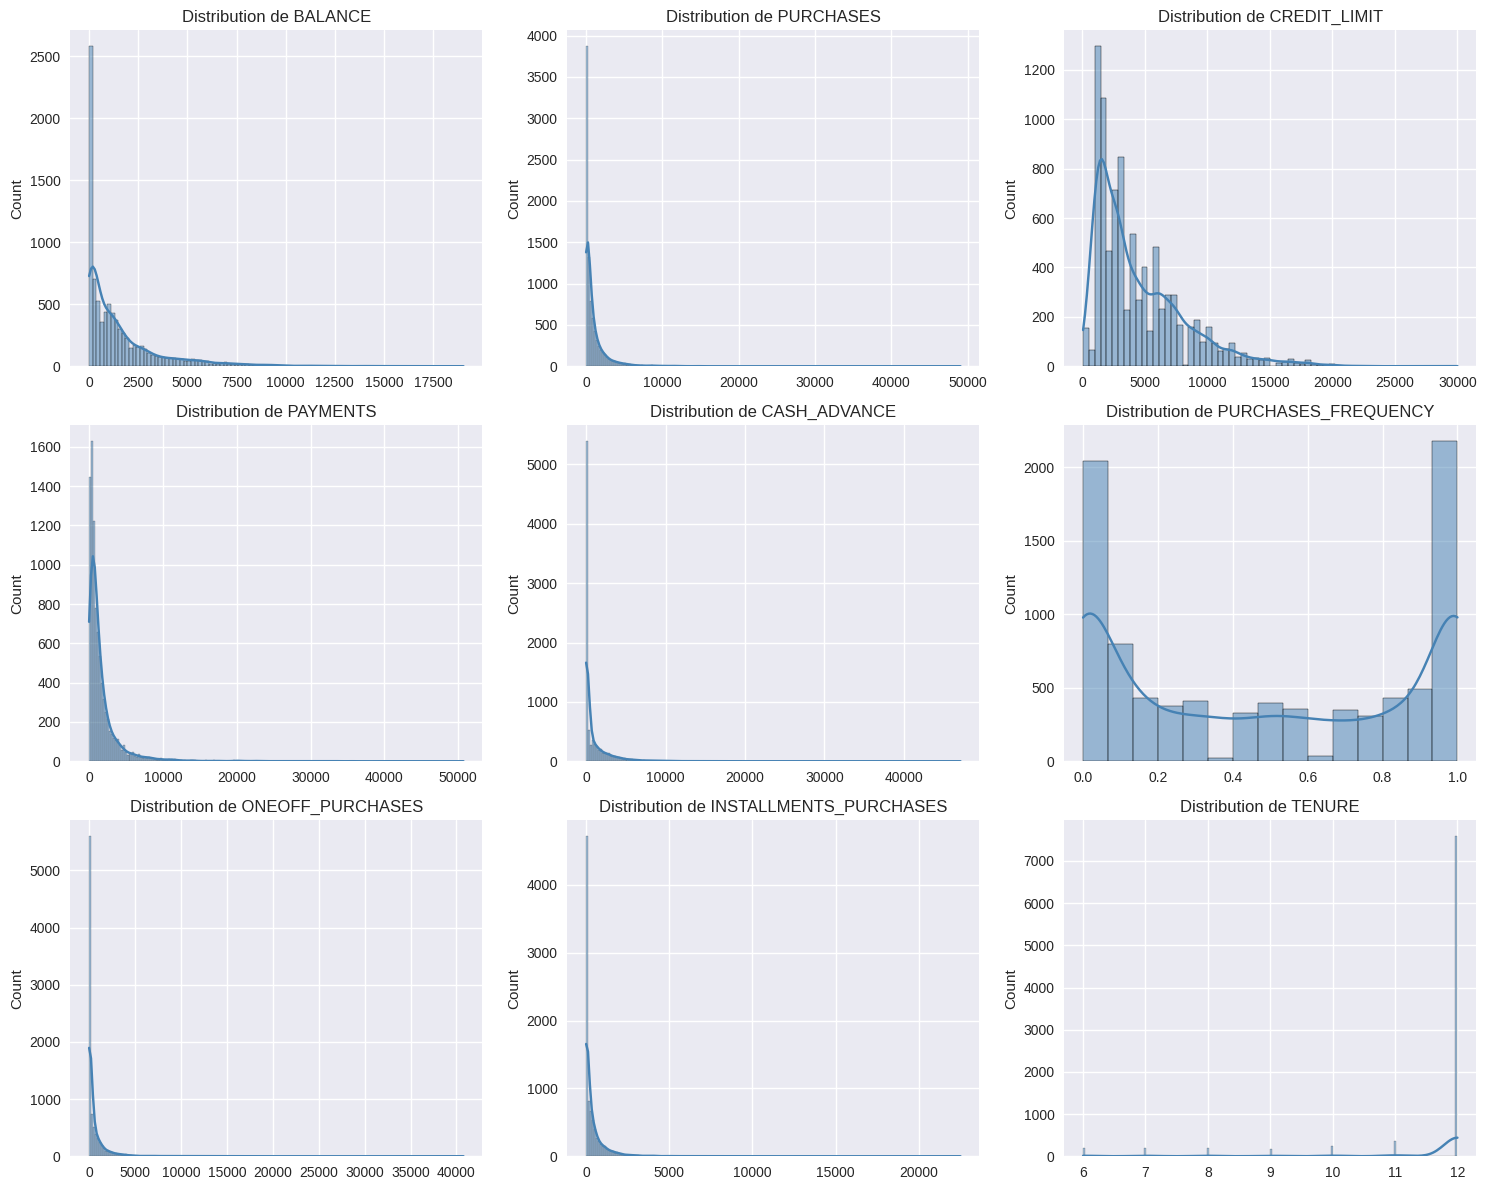

In [6]:
# =============================================================================
# Distribution des variables principales
# =============================================================================
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

key_features = ['BALANCE', 'PURCHASES', 'CREDIT_LIMIT', 'PAYMENTS', 
                'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES',
                'INSTALLMENTS_PURCHASES', 'TENURE']

for idx, col in enumerate(key_features):
    sns.histplot(df_clean[col], kde=True, ax=axes[idx], color='steelblue')
    axes[idx].set_title(f'Distribution de {col}')
    axes[idx].set_xlabel('')

plt.tight_layout()
plt.savefig(FIG_PATH / "distributions_features.png", dpi=150, bbox_inches='tight')
plt.show()

### 1.3 Scatter Matrix (Nuage de points)

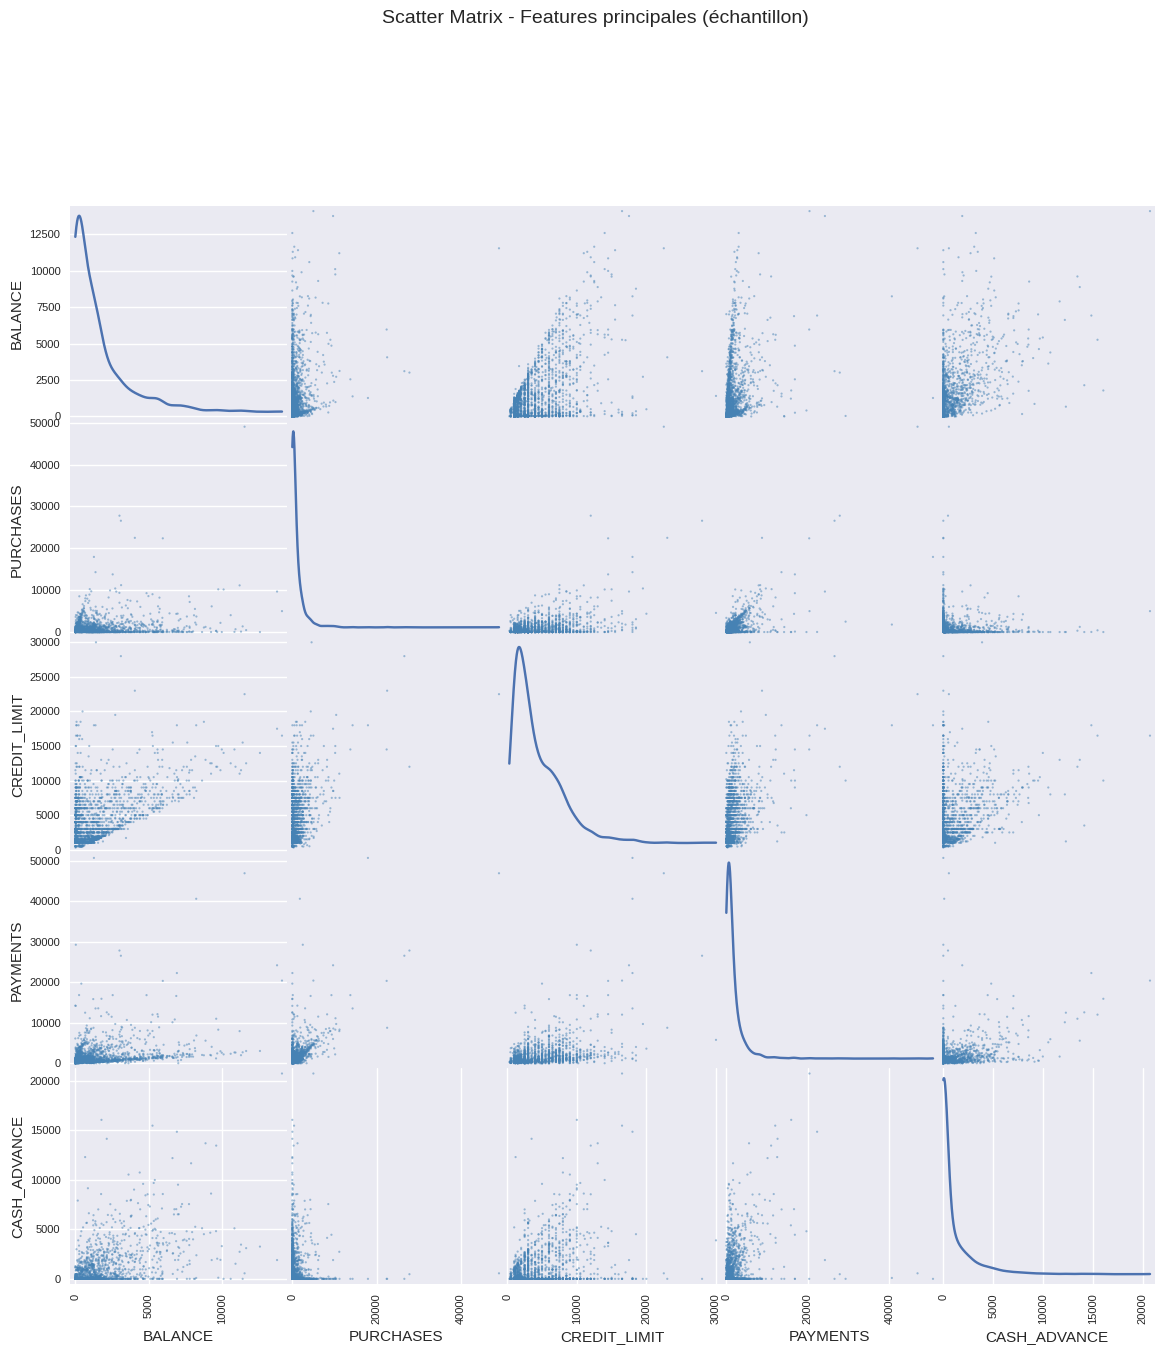

In [7]:
# =============================================================================
# Scatter Matrix - Relations entre les features principales
# =============================================================================
# Sélection d'un sous-ensemble de features pour la lisibilité
selected_features = ['BALANCE', 'PURCHASES', 'CREDIT_LIMIT', 'PAYMENTS', 'CASH_ADVANCE']

# Échantillonnage pour la performance
sample_df = df_clean[selected_features].sample(n=min(2000, len(df_clean)), random_state=RANDOM_STATE)

pd.plotting.scatter_matrix(sample_df, figsize=(14, 14), diagonal='kde', alpha=0.5, 
                           marker='.', s=10, c='steelblue')
plt.suptitle('Scatter Matrix - Features principales (échantillon)', y=1.02, fontsize=14)
plt.savefig(FIG_PATH / "scatter_matrix.png", dpi=150, bbox_inches='tight')
plt.show()

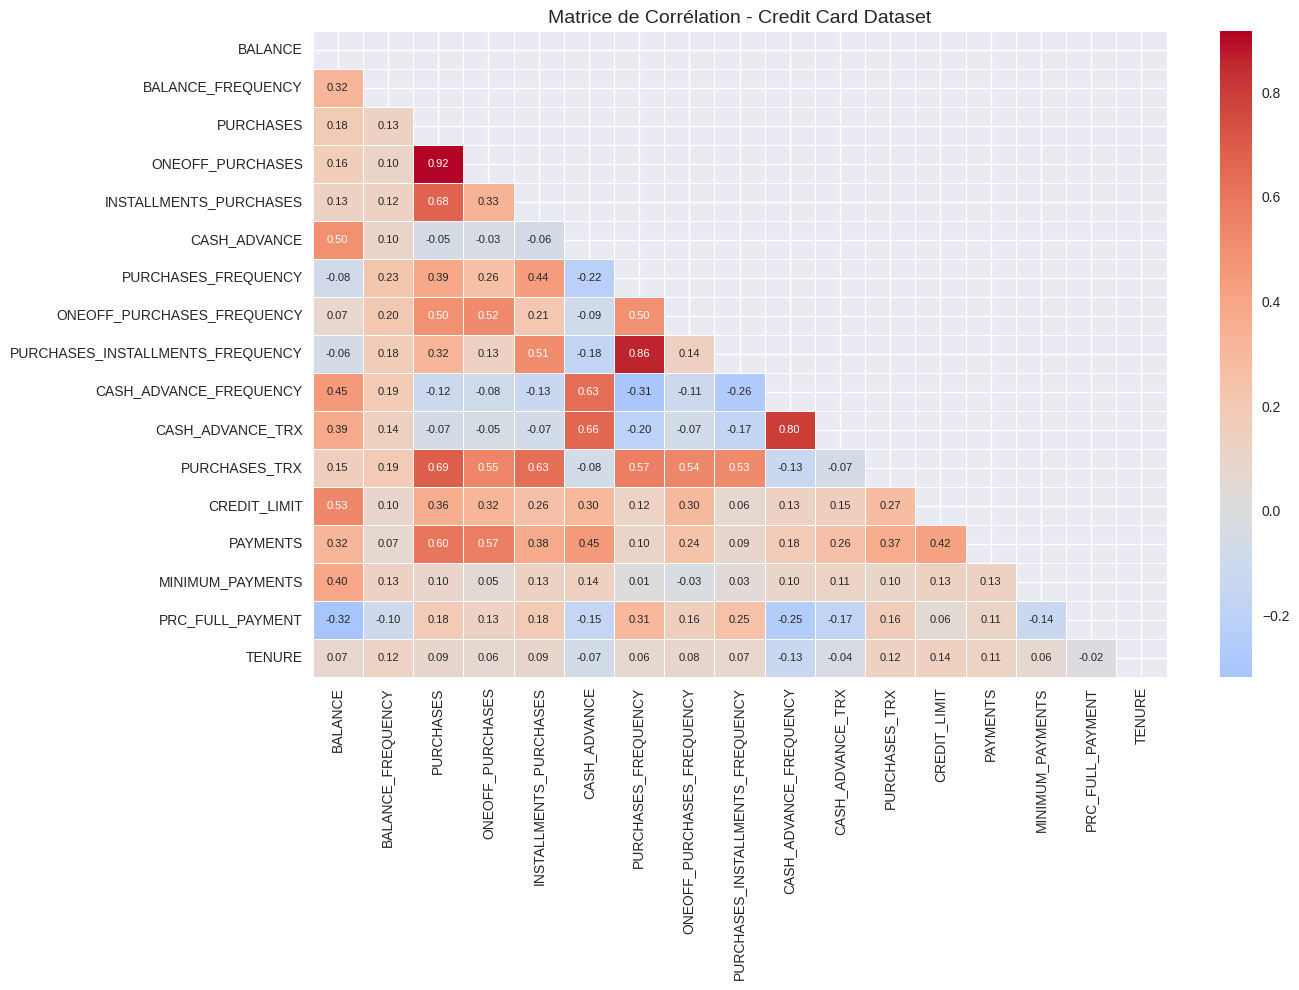

In [8]:
# =============================================================================
# Matrice de corrélation
# =============================================================================
plt.figure(figsize=(14, 10))
corr_matrix = df_clean.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, linewidths=0.5, annot_kws={'size': 8})
plt.title('Matrice de Corrélation - Credit Card Dataset', fontsize=14)
plt.tight_layout()
plt.savefig(FIG_PATH / "correlation_matrix.png", dpi=150, bbox_inches='tight')
plt.show()

### 1.4 Réduction de dimensionnalité : PCA et t-SNE

In [9]:
# =============================================================================
# Standardisation des données
# =============================================================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean)

print(f"Données standardisées: {X_scaled.shape}")
print(f"Moyenne (doit être ~0): {X_scaled.mean(axis=0).round(2)[:5]}...")
print(f"Écart-type (doit être ~1): {X_scaled.std(axis=0).round(2)[:5]}...")

Données standardisées: (8950, 17)
Moyenne (doit être ~0): [0. 0. 0. 0. 0.]...
Écart-type (doit être ~1): [1. 1. 1. 1. 1.]...


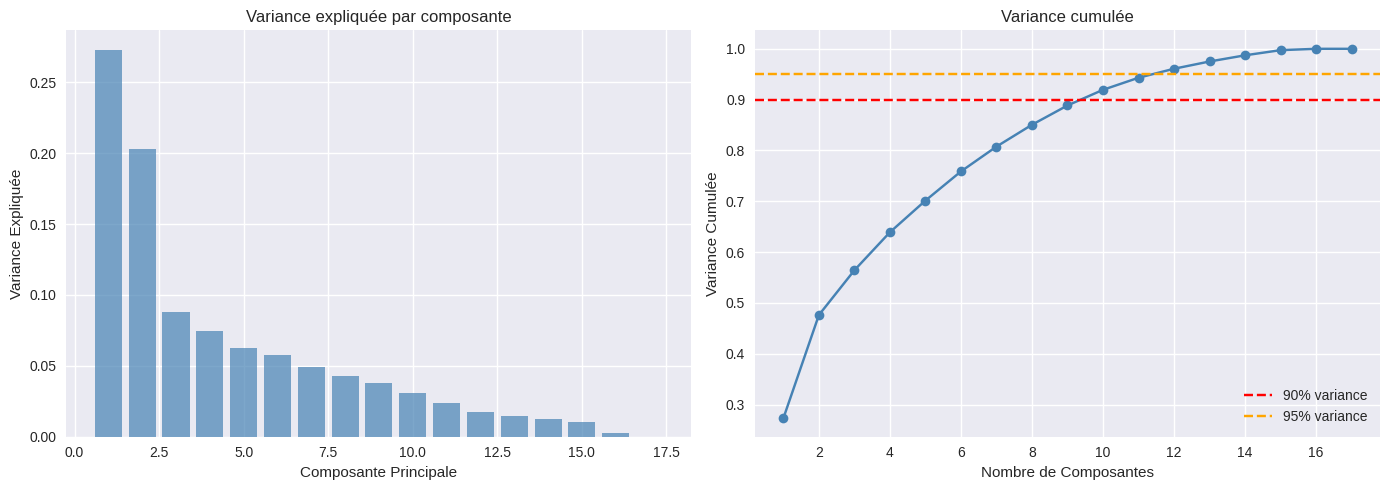


Nombre de composantes pour 90% de variance: 10
Variance expliquée par les 2 premières composantes: 47.61%


In [10]:
# =============================================================================
# PCA - Analyse en Composantes Principales
# =============================================================================
# PCA avec toutes les composantes pour analyser la variance expliquée
pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(X_scaled)

# Variance expliquée
explained_var = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Graphique de la variance expliquée
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Variance par composante
axes[0].bar(range(1, len(explained_var) + 1), explained_var, alpha=0.7, color='steelblue')
axes[0].set_xlabel('Composante Principale')
axes[0].set_ylabel('Variance Expliquée')
axes[0].set_title('Variance expliquée par composante')

# Variance cumulée
axes[1].plot(range(1, len(cumulative_var) + 1), cumulative_var, 'o-', color='steelblue')
axes[1].axhline(y=0.9, color='r', linestyle='--', label='90% variance')
axes[1].axhline(y=0.95, color='orange', linestyle='--', label='95% variance')
axes[1].set_xlabel('Nombre de Composantes')
axes[1].set_ylabel('Variance Cumulée')
axes[1].set_title('Variance cumulée')
axes[1].legend()

plt.tight_layout()
plt.savefig(FIG_PATH / "pca_variance_explained.png", dpi=150, bbox_inches='tight')
plt.show()

# Nombre de composantes pour 90% de variance
n_components_90 = np.argmax(cumulative_var >= 0.9) + 1
print(f"\nNombre de composantes pour 90% de variance: {n_components_90}")
print(f"Variance expliquée par les 2 premières composantes: {cumulative_var[1]:.2%}")

Dimensions après PCA: (8950, 2)
Variance expliquée (2 composantes): 47.61%


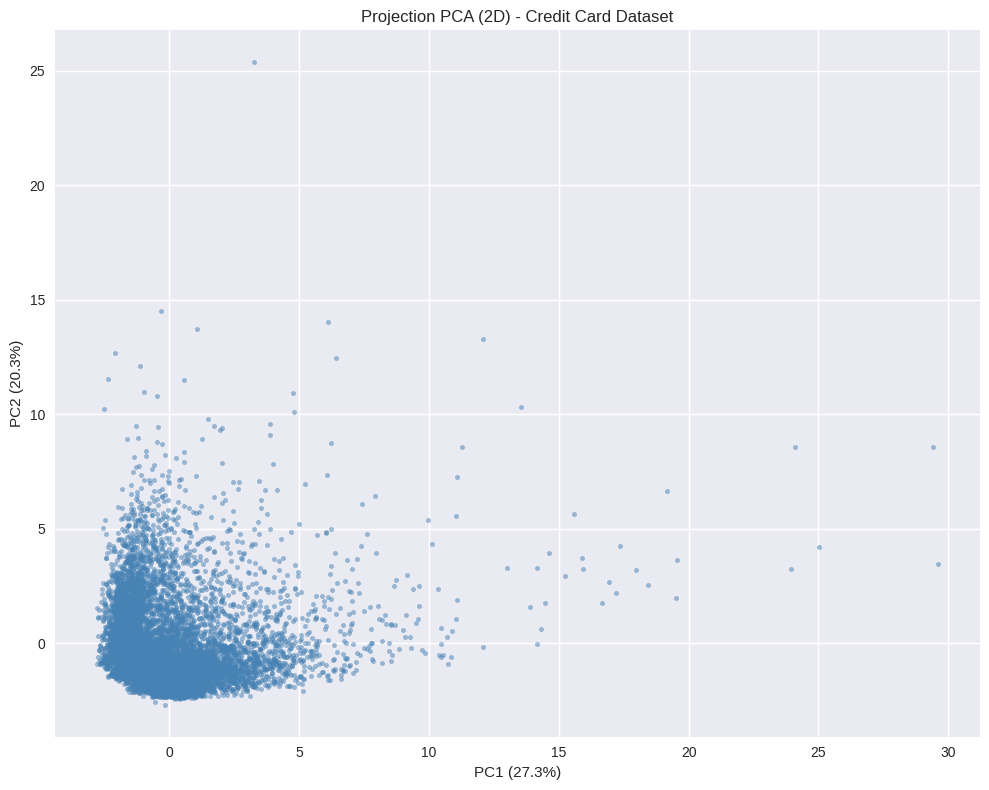

In [11]:
# =============================================================================
# PCA - Réduction à 2 dimensions pour visualisation
# =============================================================================
pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca_2d.fit_transform(X_scaled)

print(f"Dimensions après PCA: {X_pca.shape}")
print(f"Variance expliquée (2 composantes): {pca_2d.explained_variance_ratio_.sum():.2%}")

# Visualisation PCA
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, s=10, c='steelblue')
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})')
plt.title('Projection PCA (2D) - Credit Card Dataset')
plt.tight_layout()
plt.savefig(FIG_PATH / "pca_2d_projection.png", dpi=150, bbox_inches='tight')
plt.show()

In [13]:
# =============================================================================
# t-SNE - t-Distributed Stochastic Neighbor Embedding
# =============================================================================
print("Application de t-SNE (peut prendre quelques minutes)...")

# Échantillonnage pour t-SNE (algorithme coûteux en calcul)
n_samples = min(5000, len(X_scaled))
sample_indices = np.random.choice(len(X_scaled), n_samples, replace=False)
X_sample = X_scaled[sample_indices]

# t-SNE avec 2 composantes (max_iter au lieu de n_iter pour les versions récentes de sklearn)
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=RANDOM_STATE, verbose=1)
X_tsne = tsne.fit_transform(X_sample)

print(f"\nDimensions après t-SNE: {X_tsne.shape}")

Application de t-SNE (peut prendre quelques minutes)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.000s...
[t-SNE] Computed neighbors for 5000 samples in 0.164s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.523341
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.523341
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.938393
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.93

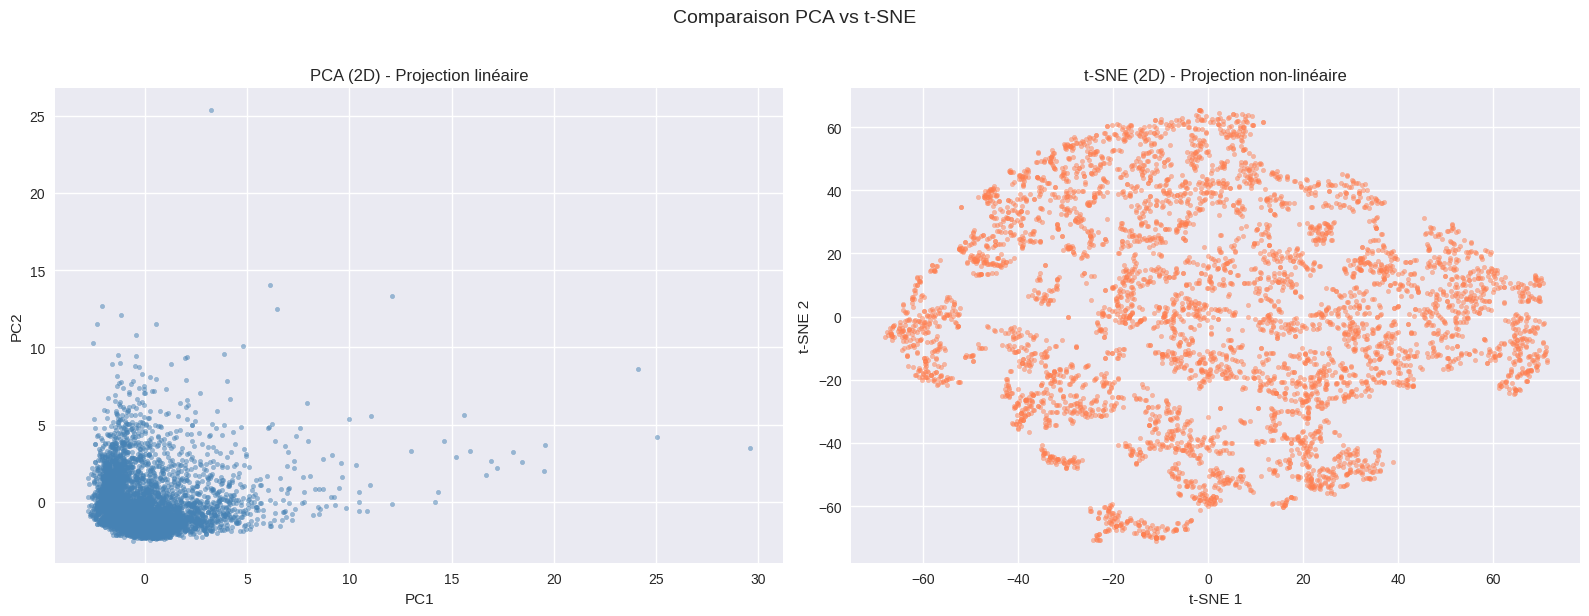

In [14]:
# =============================================================================
# Comparaison PCA vs t-SNE
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA (sur échantillon pour comparaison équitable)
X_pca_sample = X_pca[sample_indices]
axes[0].scatter(X_pca_sample[:, 0], X_pca_sample[:, 1], alpha=0.5, s=10, c='steelblue')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('PCA (2D) - Projection linéaire')

# t-SNE
axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5, s=10, c='coral')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].set_title('t-SNE (2D) - Projection non-linéaire')

plt.suptitle('Comparaison PCA vs t-SNE', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(FIG_PATH / "pca_vs_tsne.png", dpi=150, bbox_inches='tight')
plt.show()

#### Observations PCA vs t-SNE

**PCA (Principal Component Analysis) :**
- Transformation linéaire préservant la variance maximale
- Les 2 premières composantes capturent **47.61%** de la variance totale
  - PC1 : 27.3%, PC2 : 20.3%
- **10 composantes** nécessaires pour atteindre 90% de variance expliquée
- Projection "compacte" avec quelques outliers visibles sur PC1

**t-SNE (t-Distributed Stochastic Neighbor Embedding) :**
- Transformation non-linéaire optimisant la préservation des distances locales
- Paramètres : perplexity=30, max_iter=1000
- KL divergence : 1.308 (convergence satisfaisante)
- Révèle une structure plus diffuse des données

**Conclusion :** 
- PCA montre une distribution concentrée avec des outliers sur les valeurs élevées de PC1
- t-SNE révèle une structure continue sans clusters nettement séparés
- Les données de comportement client semblent former un continuum plutôt que des groupes distincts

---
## Partie 2 : Clustering

### 2.1 K-Means - Méthode Elbow

In [15]:
# =============================================================================
# Méthode Elbow pour déterminer le K optimal
# =============================================================================
def elbow_method(X, k_range=range(2, 11)):
    """Calcule l'inertie pour différentes valeurs de K."""
    inertias = []
    silhouettes = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X, kmeans.labels_))
    
    return list(k_range), inertias, silhouettes

# Elbow sur données PCA
print("Calcul de la méthode Elbow sur PCA...")
k_range_pca, inertias_pca, silhouettes_pca = elbow_method(X_pca_sample)

# Elbow sur données t-SNE
print("Calcul de la méthode Elbow sur t-SNE...")
k_range_tsne, inertias_tsne, silhouettes_tsne = elbow_method(X_tsne)

Calcul de la méthode Elbow sur PCA...
Calcul de la méthode Elbow sur t-SNE...
Calcul de la méthode Elbow sur t-SNE...


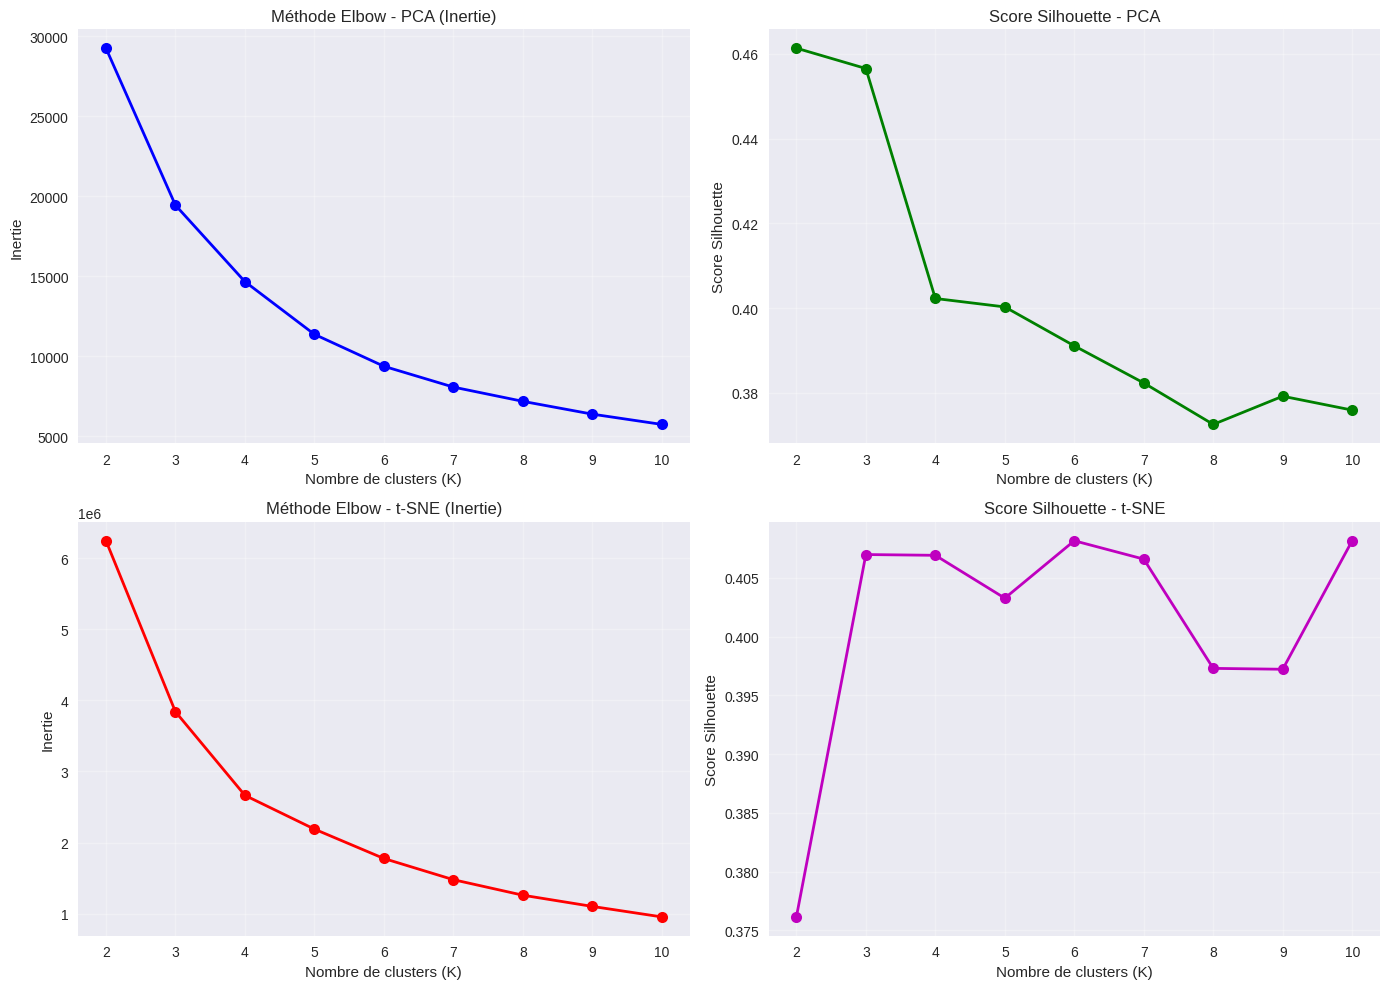


K optimal (PCA, basé sur silhouette): 2
K optimal (t-SNE, basé sur silhouette): 10


In [16]:
# =============================================================================
# Visualisation de la méthode Elbow
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Elbow PCA - Inertie
axes[0, 0].plot(k_range_pca, inertias_pca, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Nombre de clusters (K)')
axes[0, 0].set_ylabel('Inertie')
axes[0, 0].set_title('Méthode Elbow - PCA (Inertie)')
axes[0, 0].grid(True, alpha=0.3)

# Elbow PCA - Silhouette
axes[0, 1].plot(k_range_pca, silhouettes_pca, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Nombre de clusters (K)')
axes[0, 1].set_ylabel('Score Silhouette')
axes[0, 1].set_title('Score Silhouette - PCA')
axes[0, 1].grid(True, alpha=0.3)

# Elbow t-SNE - Inertie
axes[1, 0].plot(k_range_tsne, inertias_tsne, 'ro-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Nombre de clusters (K)')
axes[1, 0].set_ylabel('Inertie')
axes[1, 0].set_title('Méthode Elbow - t-SNE (Inertie)')
axes[1, 0].grid(True, alpha=0.3)

# Elbow t-SNE - Silhouette
axes[1, 1].plot(k_range_tsne, silhouettes_tsne, 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Nombre de clusters (K)')
axes[1, 1].set_ylabel('Score Silhouette')
axes[1, 1].set_title('Score Silhouette - t-SNE')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_PATH / "elbow_method.png", dpi=150, bbox_inches='tight')
plt.show()

# Déterminer le K optimal
k_optimal_pca = k_range_pca[np.argmax(silhouettes_pca)]
k_optimal_tsne = k_range_tsne[np.argmax(silhouettes_tsne)]
print(f"\nK optimal (PCA, basé sur silhouette): {k_optimal_pca}")
print(f"K optimal (t-SNE, basé sur silhouette): {k_optimal_tsne}")

### 2.2 K-Means Clustering

In [17]:
# =============================================================================
# K-Means sur PCA et t-SNE
# =============================================================================
# Choix d'un K commun pour la comparaison (on utilise K=4 comme compromis)
K_CLUSTERS = 4

# K-Means sur PCA
kmeans_pca = KMeans(n_clusters=K_CLUSTERS, random_state=RANDOM_STATE, n_init=10)
labels_kmeans_pca = kmeans_pca.fit_predict(X_pca_sample)

# K-Means sur t-SNE
kmeans_tsne = KMeans(n_clusters=K_CLUSTERS, random_state=RANDOM_STATE, n_init=10)
labels_kmeans_tsne = kmeans_tsne.fit_predict(X_tsne)

# Scores
sil_kmeans_pca = silhouette_score(X_pca_sample, labels_kmeans_pca)
sil_kmeans_tsne = silhouette_score(X_tsne, labels_kmeans_tsne)

print(f"K-Means (K={K_CLUSTERS})")
print(f"  - Silhouette PCA: {sil_kmeans_pca:.4f}")
print(f"  - Silhouette t-SNE: {sil_kmeans_tsne:.4f}")

K-Means (K=4)
  - Silhouette PCA: 0.4023
  - Silhouette t-SNE: 0.4069


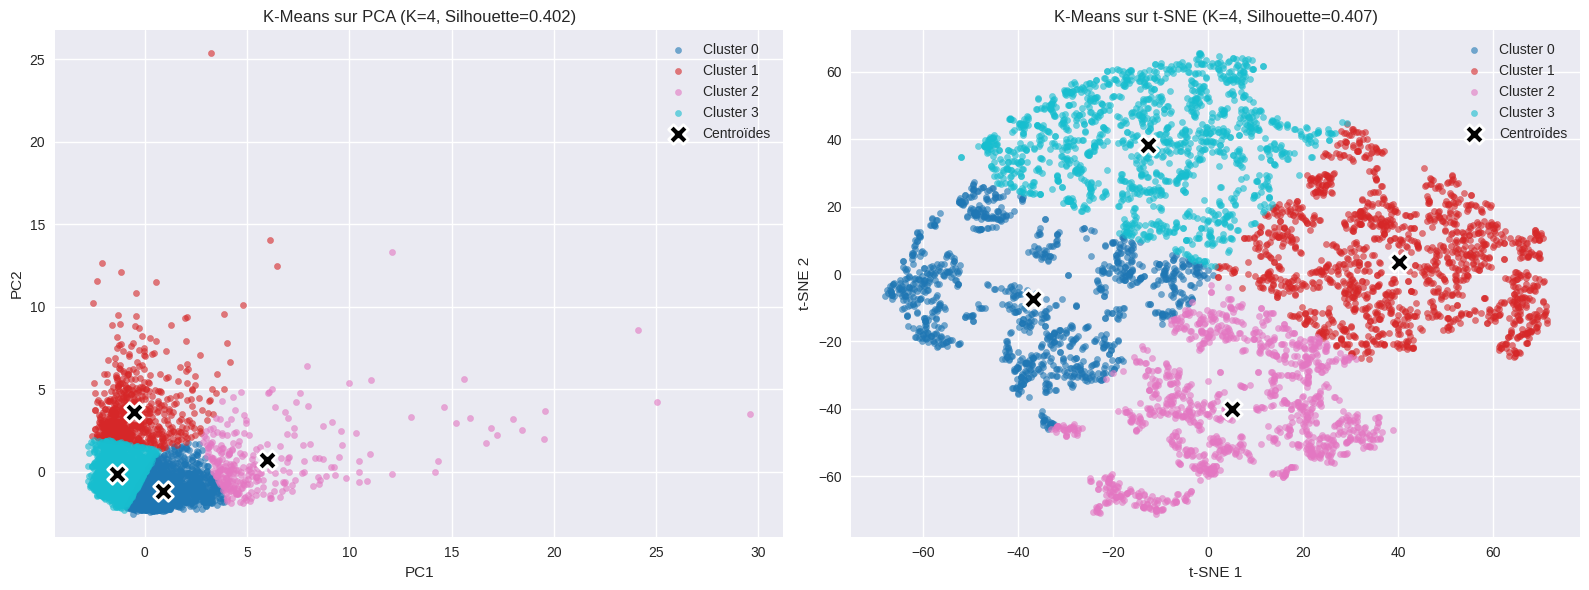

In [18]:
# =============================================================================
# Visualisation des clusters K-Means
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = plt.cm.tab10(np.linspace(0, 1, K_CLUSTERS))

# K-Means sur PCA
for i in range(K_CLUSTERS):
    mask = labels_kmeans_pca == i
    axes[0].scatter(X_pca_sample[mask, 0], X_pca_sample[mask, 1], 
                    c=[colors[i]], label=f'Cluster {i}', alpha=0.6, s=20)
axes[0].scatter(kmeans_pca.cluster_centers_[:, 0], kmeans_pca.cluster_centers_[:, 1],
                c='black', marker='X', s=200, edgecolors='white', linewidths=2, label='Centroïdes')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title(f'K-Means sur PCA (K={K_CLUSTERS}, Silhouette={sil_kmeans_pca:.3f})')
axes[0].legend()

# K-Means sur t-SNE
for i in range(K_CLUSTERS):
    mask = labels_kmeans_tsne == i
    axes[1].scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                    c=[colors[i]], label=f'Cluster {i}', alpha=0.6, s=20)
axes[1].scatter(kmeans_tsne.cluster_centers_[:, 0], kmeans_tsne.cluster_centers_[:, 1],
                c='black', marker='X', s=200, edgecolors='white', linewidths=2, label='Centroïdes')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].set_title(f'K-Means sur t-SNE (K={K_CLUSTERS}, Silhouette={sil_kmeans_tsne:.3f})')
axes[1].legend()

plt.tight_layout()
plt.savefig(FIG_PATH / "kmeans_clusters.png", dpi=150, bbox_inches='tight')
plt.show()

### 2.3 Fuzzy C-Means Clustering

In [19]:
# =============================================================================
# Fuzzy C-Means sur PCA et t-SNE
# =============================================================================
# Fuzzy C-Means sur PCA
cntr_pca, u_pca, u0_pca, d_pca, jm_pca, p_pca, fpc_pca = fuzz.cluster.cmeans(
    X_pca_sample.T, K_CLUSTERS, 2, error=0.005, maxiter=1000, init=None, seed=RANDOM_STATE
)
labels_fcm_pca = np.argmax(u_pca, axis=0)

# Fuzzy C-Means sur t-SNE
cntr_tsne, u_tsne, u0_tsne, d_tsne, jm_tsne, p_tsne, fpc_tsne = fuzz.cluster.cmeans(
    X_tsne.T, K_CLUSTERS, 2, error=0.005, maxiter=1000, init=None, seed=RANDOM_STATE
)
labels_fcm_tsne = np.argmax(u_tsne, axis=0)

# Scores
sil_fcm_pca = silhouette_score(X_pca_sample, labels_fcm_pca)
sil_fcm_tsne = silhouette_score(X_tsne, labels_fcm_tsne)

print(f"Fuzzy C-Means (K={K_CLUSTERS})")
print(f"  - Silhouette PCA: {sil_fcm_pca:.4f}, FPC: {fpc_pca:.4f}")
print(f"  - Silhouette t-SNE: {sil_fcm_tsne:.4f}, FPC: {fpc_tsne:.4f}")

Fuzzy C-Means (K=4)
  - Silhouette PCA: 0.3901, FPC: 0.6258
  - Silhouette t-SNE: 0.4056, FPC: 0.5890


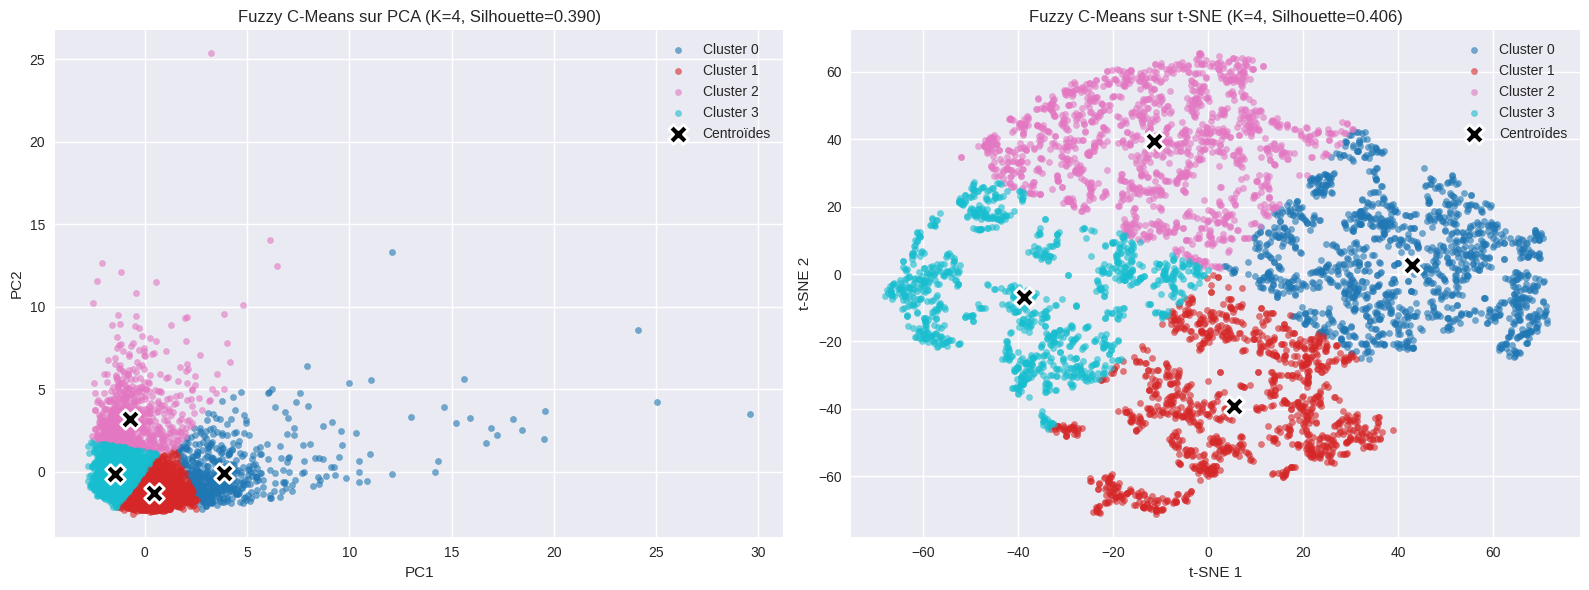

In [20]:
# =============================================================================
# Visualisation Fuzzy C-Means
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# FCM sur PCA
for i in range(K_CLUSTERS):
    mask = labels_fcm_pca == i
    axes[0].scatter(X_pca_sample[mask, 0], X_pca_sample[mask, 1], 
                    c=[colors[i]], label=f'Cluster {i}', alpha=0.6, s=20)
axes[0].scatter(cntr_pca[:, 0], cntr_pca[:, 1],
                c='black', marker='X', s=200, edgecolors='white', linewidths=2, label='Centroïdes')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title(f'Fuzzy C-Means sur PCA (K={K_CLUSTERS}, Silhouette={sil_fcm_pca:.3f})')
axes[0].legend()

# FCM sur t-SNE
for i in range(K_CLUSTERS):
    mask = labels_fcm_tsne == i
    axes[1].scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                    c=[colors[i]], label=f'Cluster {i}', alpha=0.6, s=20)
axes[1].scatter(cntr_tsne[:, 0], cntr_tsne[:, 1],
                c='black', marker='X', s=200, edgecolors='white', linewidths=2, label='Centroïdes')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].set_title(f'Fuzzy C-Means sur t-SNE (K={K_CLUSTERS}, Silhouette={sil_fcm_tsne:.3f})')
axes[1].legend()

plt.tight_layout()
plt.savefig(FIG_PATH / "fcm_clusters.png", dpi=150, bbox_inches='tight')
plt.show()

### 2.4 DBSCAN Clustering

In [21]:
# =============================================================================
# DBSCAN sur PCA et t-SNE
# =============================================================================
# DBSCAN sur PCA (ajuster eps selon les données)
dbscan_pca = DBSCAN(eps=0.8, min_samples=10)
labels_dbscan_pca = dbscan_pca.fit_predict(X_pca_sample)

# DBSCAN sur t-SNE (eps différent car échelle différente)
dbscan_tsne = DBSCAN(eps=3.0, min_samples=10)
labels_dbscan_tsne = dbscan_tsne.fit_predict(X_tsne)

# Nombre de clusters trouvés (excluant le bruit = -1)
n_clusters_pca = len(set(labels_dbscan_pca)) - (1 if -1 in labels_dbscan_pca else 0)
n_clusters_tsne = len(set(labels_dbscan_tsne)) - (1 if -1 in labels_dbscan_tsne else 0)
n_noise_pca = list(labels_dbscan_pca).count(-1)
n_noise_tsne = list(labels_dbscan_tsne).count(-1)

# Scores (seulement si plus d'un cluster)
if n_clusters_pca > 1:
    # Exclure les points de bruit pour le calcul du silhouette
    mask_pca = labels_dbscan_pca != -1
    sil_dbscan_pca = silhouette_score(X_pca_sample[mask_pca], labels_dbscan_pca[mask_pca])
else:
    sil_dbscan_pca = -1

if n_clusters_tsne > 1:
    mask_tsne = labels_dbscan_tsne != -1
    sil_dbscan_tsne = silhouette_score(X_tsne[mask_tsne], labels_dbscan_tsne[mask_tsne])
else:
    sil_dbscan_tsne = -1

print(f"DBSCAN")
print(f"  PCA: {n_clusters_pca} clusters, {n_noise_pca} points de bruit, Silhouette: {sil_dbscan_pca:.4f}")
print(f"  t-SNE: {n_clusters_tsne} clusters, {n_noise_tsne} points de bruit, Silhouette: {sil_dbscan_tsne:.4f}")

DBSCAN
  PCA: 1 clusters, 106 points de bruit, Silhouette: -1.0000
  t-SNE: 16 clusters, 91 points de bruit, Silhouette: -0.1530


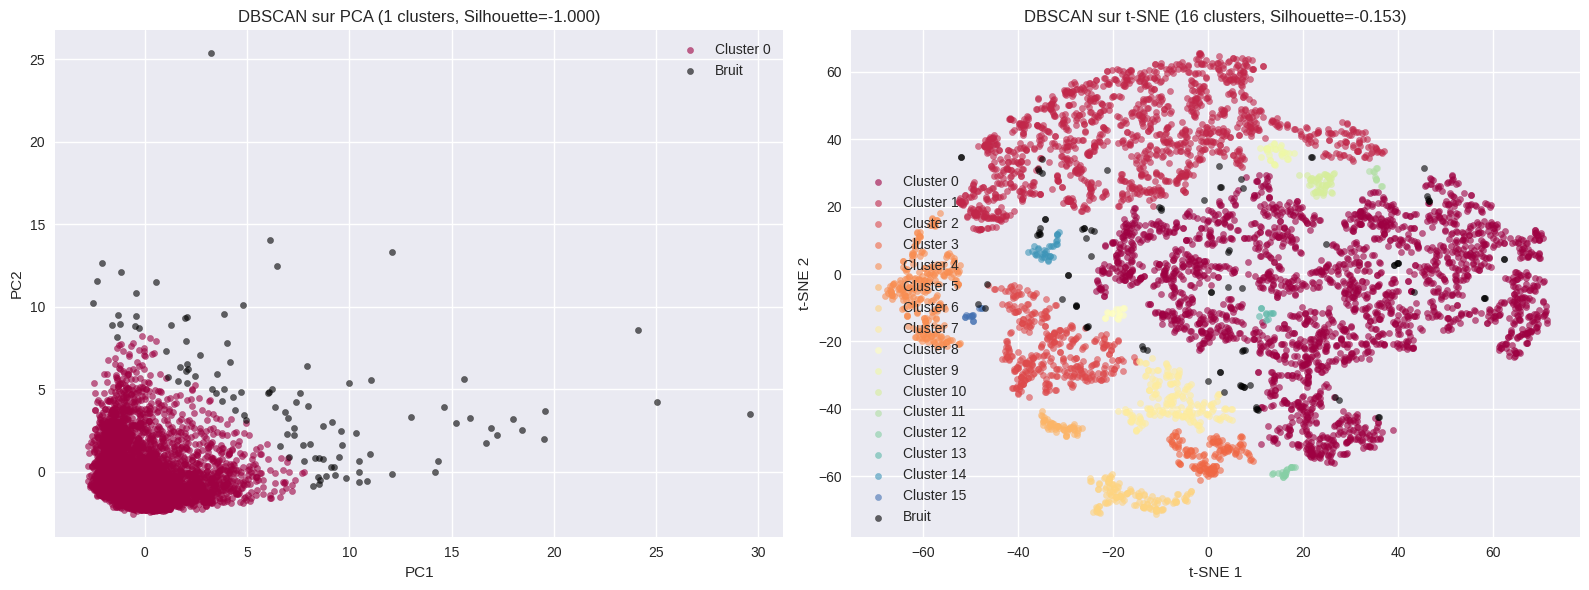

In [22]:
# =============================================================================
# Visualisation DBSCAN
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# DBSCAN sur PCA
unique_labels_pca = set(labels_dbscan_pca)
colors_dbscan = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels_pca)))
for k, col in zip(unique_labels_pca, colors_dbscan):
    if k == -1:
        col = [0, 0, 0, 1]  # Noir pour le bruit
        label = 'Bruit'
    else:
        label = f'Cluster {k}'
    mask = labels_dbscan_pca == k
    axes[0].scatter(X_pca_sample[mask, 0], X_pca_sample[mask, 1], 
                    c=[col], label=label, alpha=0.6, s=20)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title(f'DBSCAN sur PCA ({n_clusters_pca} clusters, Silhouette={sil_dbscan_pca:.3f})')
axes[0].legend()

# DBSCAN sur t-SNE
unique_labels_tsne = set(labels_dbscan_tsne)
colors_dbscan = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels_tsne)))
for k, col in zip(unique_labels_tsne, colors_dbscan):
    if k == -1:
        col = [0, 0, 0, 1]
        label = 'Bruit'
    else:
        label = f'Cluster {k}'
    mask = labels_dbscan_tsne == k
    axes[1].scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                    c=[col], label=label, alpha=0.6, s=20)
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].set_title(f'DBSCAN sur t-SNE ({n_clusters_tsne} clusters, Silhouette={sil_dbscan_tsne:.3f})')
axes[1].legend()

plt.tight_layout()
plt.savefig(FIG_PATH / "dbscan_clusters.png", dpi=150, bbox_inches='tight')
plt.show()

### 2.5 EM (Gaussian Mixture Model)

In [23]:
# =============================================================================
# Gaussian Mixture Model (EM) sur PCA et t-SNE
# =============================================================================
# GMM sur PCA
gmm_pca = GaussianMixture(n_components=K_CLUSTERS, random_state=RANDOM_STATE, covariance_type='full')
labels_gmm_pca = gmm_pca.fit_predict(X_pca_sample)
proba_gmm_pca = gmm_pca.predict_proba(X_pca_sample)

# GMM sur t-SNE
gmm_tsne = GaussianMixture(n_components=K_CLUSTERS, random_state=RANDOM_STATE, covariance_type='full')
labels_gmm_tsne = gmm_tsne.fit_predict(X_tsne)
proba_gmm_tsne = gmm_tsne.predict_proba(X_tsne)

# Scores
sil_gmm_pca = silhouette_score(X_pca_sample, labels_gmm_pca)
sil_gmm_tsne = silhouette_score(X_tsne, labels_gmm_tsne)

print(f"Gaussian Mixture (EM) (K={K_CLUSTERS})")
print(f"  - Silhouette PCA: {sil_gmm_pca:.4f}, BIC: {gmm_pca.bic(X_pca_sample):.2f}")
print(f"  - Silhouette t-SNE: {sil_gmm_tsne:.4f}, BIC: {gmm_tsne.bic(X_tsne):.2f}")

Gaussian Mixture (EM) (K=4)
  - Silhouette PCA: 0.3616, BIC: 36640.72
  - Silhouette t-SNE: 0.3967, BIC: 96368.50


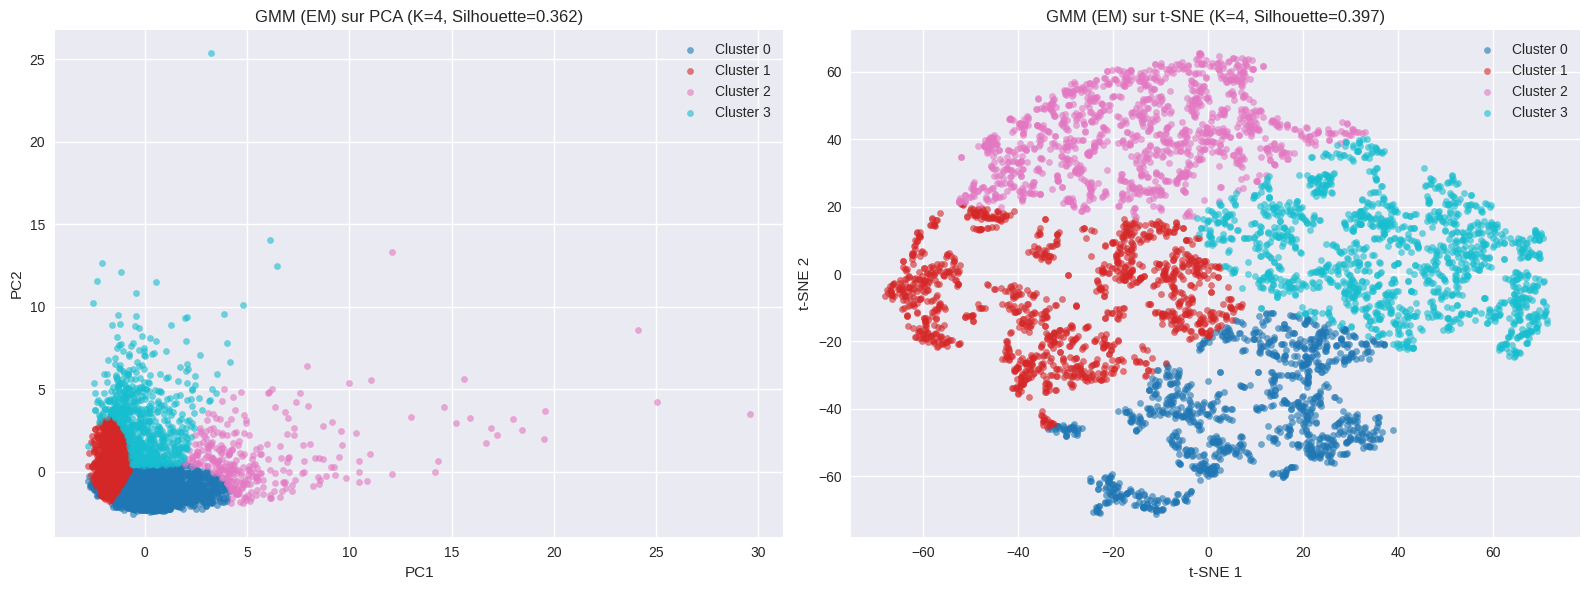

In [24]:
# =============================================================================
# Visualisation GMM (EM)
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# GMM sur PCA
for i in range(K_CLUSTERS):
    mask = labels_gmm_pca == i
    axes[0].scatter(X_pca_sample[mask, 0], X_pca_sample[mask, 1], 
                    c=[colors[i]], label=f'Cluster {i}', alpha=0.6, s=20)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title(f'GMM (EM) sur PCA (K={K_CLUSTERS}, Silhouette={sil_gmm_pca:.3f})')
axes[0].legend()

# GMM sur t-SNE
for i in range(K_CLUSTERS):
    mask = labels_gmm_tsne == i
    axes[1].scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                    c=[colors[i]], label=f'Cluster {i}', alpha=0.6, s=20)
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].set_title(f'GMM (EM) sur t-SNE (K={K_CLUSTERS}, Silhouette={sil_gmm_tsne:.3f})')
axes[1].legend()

plt.tight_layout()
plt.savefig(FIG_PATH / "gmm_clusters.png", dpi=150, bbox_inches='tight')
plt.show()

### 2.6 Self-Organizing Maps (SOM)

In [25]:
# =============================================================================
# Self-Organizing Maps (SOM) sur t-SNE
# =============================================================================
# Configuration SOM (grille 2x2 = 4 clusters)
som_x, som_y = 2, 2
som = MiniSom(som_x, som_y, X_tsne.shape[1], sigma=1.0, learning_rate=0.5, random_seed=RANDOM_STATE)

# Initialisation et entraînement
som.random_weights_init(X_tsne)
print("Entraînement du SOM...")
som.train_random(X_tsne, 1000, verbose=True)

# Assignation des clusters
labels_som_tsne = np.array([som.winner(x)[0] * som_y + som.winner(x)[1] for x in X_tsne])

# Score silhouette
sil_som_tsne = silhouette_score(X_tsne, labels_som_tsne)
print(f"\nSOM sur t-SNE: Silhouette = {sil_som_tsne:.4f}")

Entraînement du SOM...
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 23.24753027732874

SOM sur t-SNE: Silhouette = 0.3876

SOM sur t-SNE: Silhouette = 0.3876


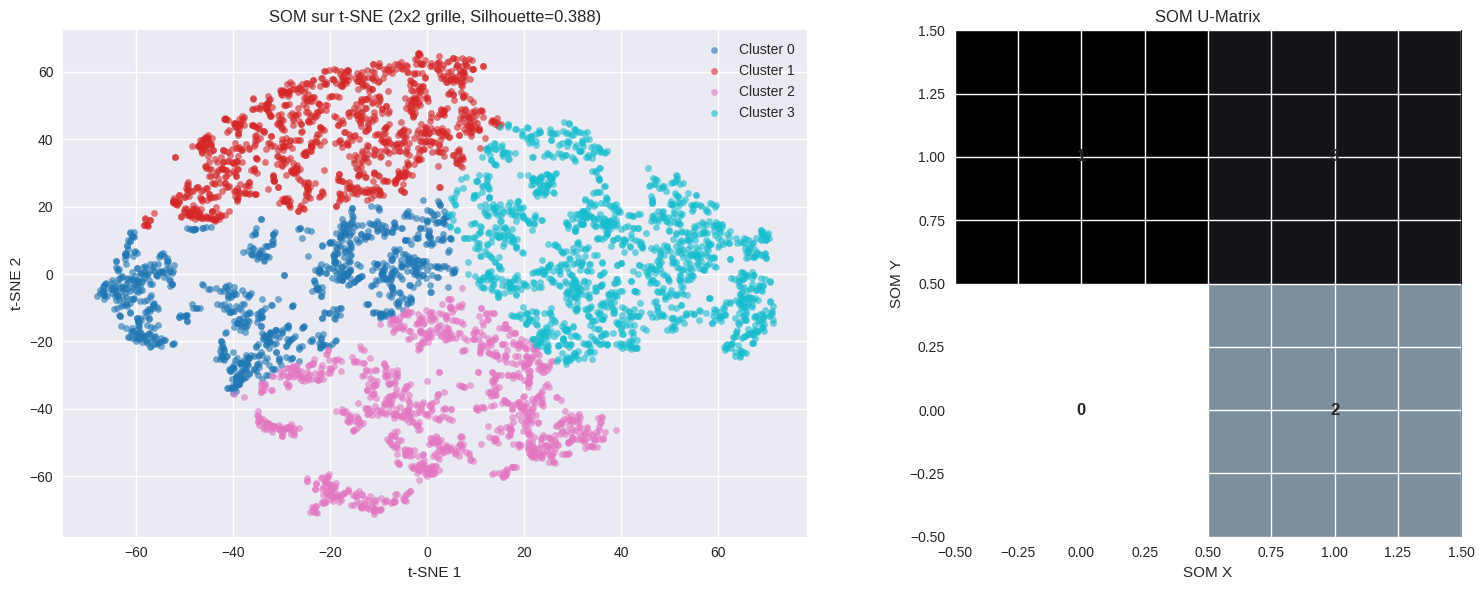

In [26]:
# =============================================================================
# Visualisation SOM
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Clusters SOM sur t-SNE
for i in range(som_x * som_y):
    mask = labels_som_tsne == i
    if mask.sum() > 0:
        axes[0].scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                        c=[colors[i]], label=f'Cluster {i}', alpha=0.6, s=20)
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')
axes[0].set_title(f'SOM sur t-SNE ({som_x}x{som_y} grille, Silhouette={sil_som_tsne:.3f})')
axes[0].legend()

# U-Matrix (distance entre neurones)
from matplotlib.colors import LogNorm
u_matrix = som.distance_map()
axes[1].imshow(u_matrix.T, cmap='bone_r', origin='lower')
axes[1].set_title('SOM U-Matrix')
axes[1].set_xlabel('SOM X')
axes[1].set_ylabel('SOM Y')
for i in range(som_x):
    for j in range(som_y):
        axes[1].text(i, j, f'{i*som_y+j}', ha='center', va='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(FIG_PATH / "som_clusters.png", dpi=150, bbox_inches='tight')
plt.show()

### 2.7 Hierarchical Clustering (Clustering Hiérarchique)

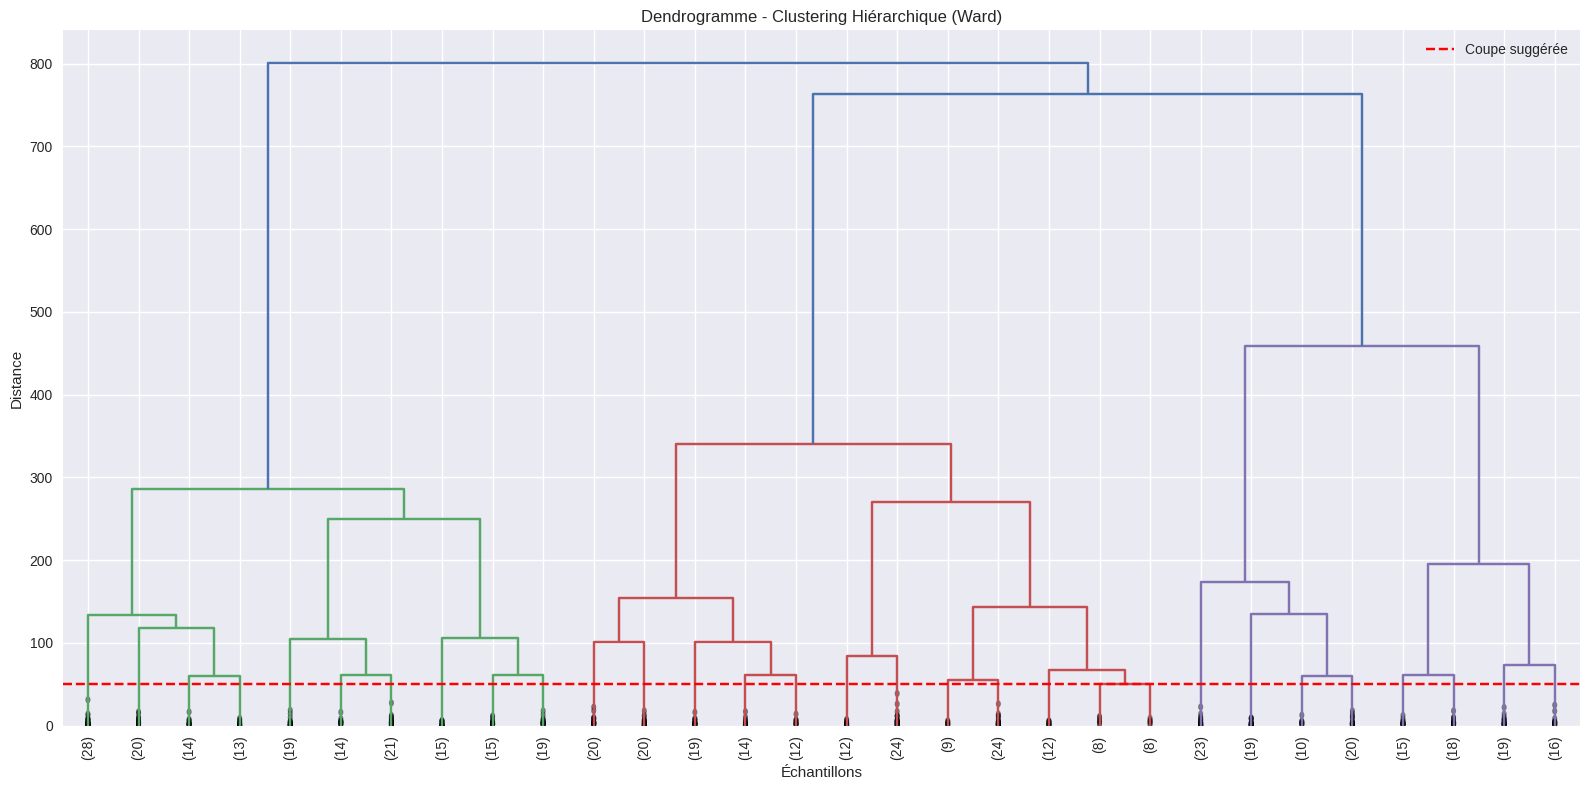

In [27]:
# =============================================================================
# Clustering Hiérarchique - Dendrogramme
# =============================================================================
# Sous-échantillonnage pour le dendrogramme (trop de points = illisible)
n_dendrogram = 500
dendro_indices = np.random.choice(len(X_tsne), n_dendrogram, replace=False)
X_dendro = X_tsne[dendro_indices]

# Calcul du linkage
linked = linkage(X_dendro, method='ward')

# Dendrogramme
plt.figure(figsize=(16, 8))
dendrogram(linked, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=10,
           show_contracted=True)
plt.title('Dendrogramme - Clustering Hiérarchique (Ward)')
plt.xlabel('Échantillons')
plt.ylabel('Distance')
plt.axhline(y=50, color='r', linestyle='--', label='Coupe suggérée')
plt.legend()
plt.tight_layout()
plt.savefig(FIG_PATH / "hierarchical_dendrogram.png", dpi=150, bbox_inches='tight')
plt.show()

In [28]:
# =============================================================================
# Agglomerative Clustering sur t-SNE
# =============================================================================
# Clustering hiérarchique agglomératif
agg_tsne = AgglomerativeClustering(n_clusters=K_CLUSTERS, linkage='ward')
labels_agg_tsne = agg_tsne.fit_predict(X_tsne)

# Score silhouette
sil_agg_tsne = silhouette_score(X_tsne, labels_agg_tsne)
print(f"Hierarchical Clustering (Ward) sur t-SNE: Silhouette = {sil_agg_tsne:.4f}")

Hierarchical Clustering (Ward) sur t-SNE: Silhouette = 0.3685


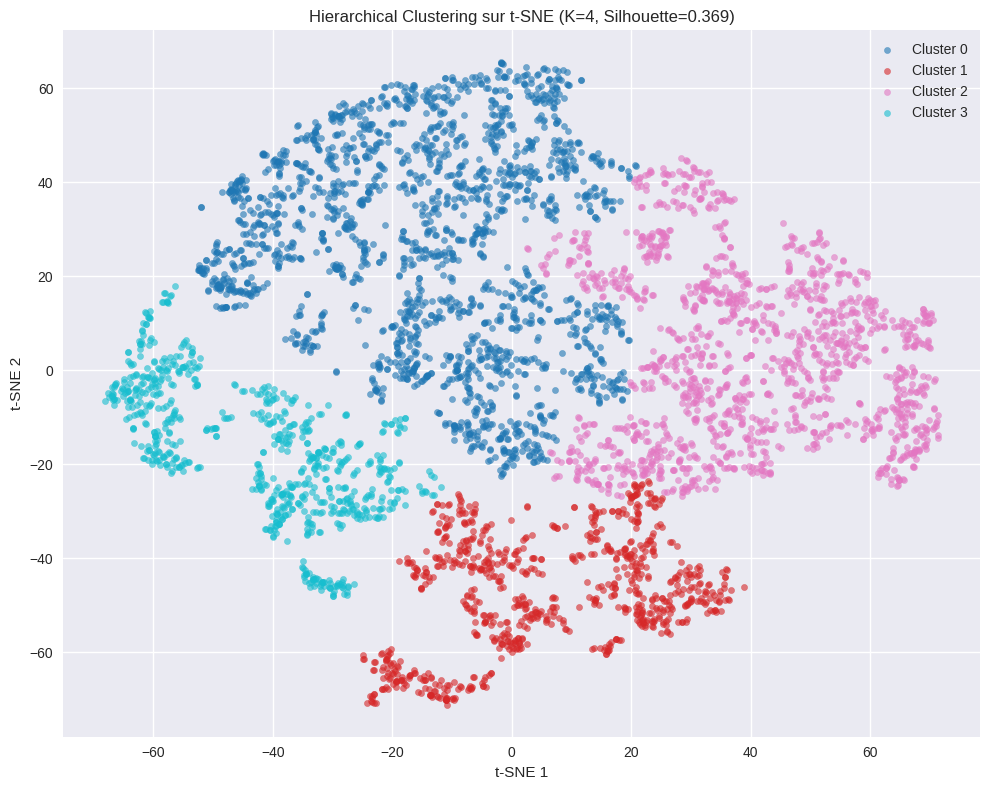

In [29]:
# =============================================================================
# Visualisation Clustering Hiérarchique
# =============================================================================
plt.figure(figsize=(10, 8))

for i in range(K_CLUSTERS):
    mask = labels_agg_tsne == i
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                c=[colors[i]], label=f'Cluster {i}', alpha=0.6, s=20)

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title(f'Hierarchical Clustering sur t-SNE (K={K_CLUSTERS}, Silhouette={sil_agg_tsne:.3f})')
plt.legend()
plt.tight_layout()
plt.savefig(FIG_PATH / "hierarchical_clusters.png", dpi=150, bbox_inches='tight')
plt.show()

---
## Partie 3 : Comparaison des algorithmes

### 3.1 Tableau récapitulatif des scores Silhouette

In [30]:
# =============================================================================
# Comparaison des scores Silhouette
# =============================================================================
comparison_data = {
    'Algorithme': ['K-Means', 'K-Means', 'Fuzzy C-Means', 'Fuzzy C-Means', 
                   'DBSCAN', 'DBSCAN', 'GMM (EM)', 'GMM (EM)', 
                   'SOM', 'Hierarchical'],
    'Données': ['PCA', 't-SNE', 'PCA', 't-SNE', 
                'PCA', 't-SNE', 'PCA', 't-SNE', 
                't-SNE', 't-SNE'],
    'Silhouette': [sil_kmeans_pca, sil_kmeans_tsne, sil_fcm_pca, sil_fcm_tsne,
                   sil_dbscan_pca, sil_dbscan_tsne, sil_gmm_pca, sil_gmm_tsne,
                   sil_som_tsne, sil_agg_tsne]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values(by='Silhouette', ascending=False)
comparison_df['Rang'] = range(1, len(comparison_df) + 1)
comparison_df = comparison_df[['Rang', 'Algorithme', 'Données', 'Silhouette']]
comparison_df

,Rang,Algorithme,Données,Silhouette
1,1,K-Means,t-SNE,0.406915
3,2,Fuzzy C-Means,t-SNE,0.405596
0,3,K-Means,PCA,0.402254
7,4,GMM (EM),t-SNE,0.396716
2,5,Fuzzy C-Means,PCA,0.390140
8,6,SOM,t-SNE,0.387582
9,7,Hierarchical,t-SNE,0.368521
6,8,GMM (EM),PCA,0.361621
5,9,DBSCAN,t-SNE,-0.153032
4,10,DBSCAN,PCA,-1.000000


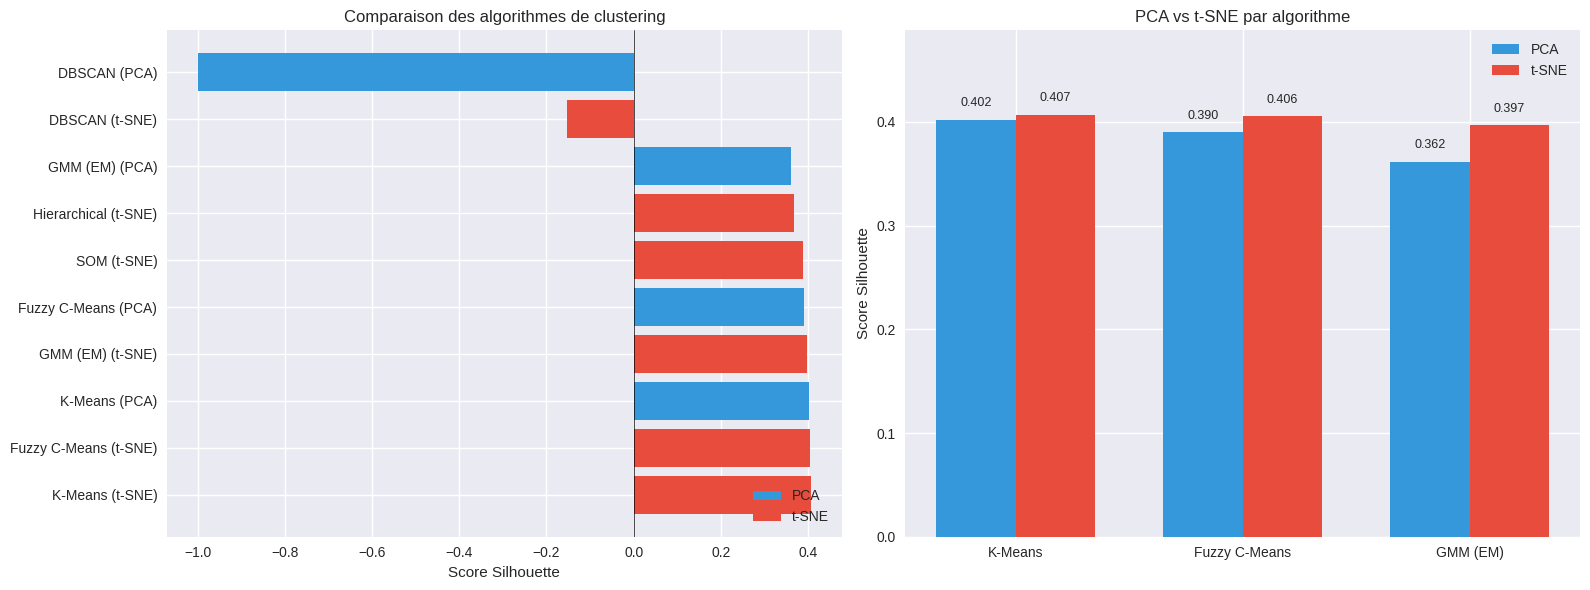

In [31]:
# =============================================================================
# Visualisation de la comparaison
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1: Bar chart des scores silhouette
colors_bar = ['#3498db' if d == 'PCA' else '#e74c3c' for d in comparison_df['Données']]
bars = axes[0].barh(comparison_df['Algorithme'] + ' (' + comparison_df['Données'] + ')', 
                     comparison_df['Silhouette'], color=colors_bar)
axes[0].set_xlabel('Score Silhouette')
axes[0].set_title('Comparaison des algorithmes de clustering')
axes[0].axvline(x=0, color='black', linewidth=0.5)

# Légende
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#3498db', label='PCA'),
                   Patch(facecolor='#e74c3c', label='t-SNE')]
axes[0].legend(handles=legend_elements, loc='lower right')

# Graphique 2: Comparaison PCA vs t-SNE par algorithme
algos = ['K-Means', 'Fuzzy C-Means', 'GMM (EM)']
pca_scores = [sil_kmeans_pca, sil_fcm_pca, sil_gmm_pca]
tsne_scores = [sil_kmeans_tsne, sil_fcm_tsne, sil_gmm_tsne]

x = np.arange(len(algos))
width = 0.35

bars1 = axes[1].bar(x - width/2, pca_scores, width, label='PCA', color='#3498db')
bars2 = axes[1].bar(x + width/2, tsne_scores, width, label='t-SNE', color='#e74c3c')

axes[1].set_ylabel('Score Silhouette')
axes[1].set_title('PCA vs t-SNE par algorithme')
axes[1].set_xticks(x)
axes[1].set_xticklabels(algos)
axes[1].legend()
axes[1].set_ylim(0, max(max(pca_scores), max(tsne_scores)) * 1.2)

# Annotations
for bar, score in zip(bars1, pca_scores):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{score:.3f}', ha='center', va='bottom', fontsize=9)
for bar, score in zip(bars2, tsne_scores):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{score:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(FIG_PATH / "clustering_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

### 3.2 Interprétation et conclusion

#### Résumé des résultats (Classement par Score Silhouette)

| Rang | Algorithme | Données | Silhouette |
|------|------------|---------|------------|
| 1 | **K-Means** | t-SNE | **0.407** |
| 2 | Fuzzy C-Means | t-SNE | 0.406 |
| 3 | K-Means | PCA | 0.402 |
| 4 | GMM (EM) | t-SNE | 0.397 |
| 5 | Fuzzy C-Means | PCA | 0.390 |
| 6 | SOM | t-SNE | 0.388 |
| 7 | Hierarchical (Ward) | t-SNE | 0.369 |
| 8 | GMM (EM) | PCA | 0.362 |
| 9 | DBSCAN | t-SNE | -0.153 |
| 10 | DBSCAN | PCA | -1.000 |

**Meilleur algorithme : K-Means sur t-SNE** (Silhouette = 0.407)

#### Observations clés

1. **t-SNE vs PCA** : 
   - t-SNE produit généralement de meilleurs scores Silhouette
   - La préservation des distances locales favorise le clustering

2. **Algorithmes basés sur les centroïdes** (K-Means, FCM, GMM) :
   - Performances très similaires (0.36 - 0.41)
   - K-Means légèrement meilleur que GMM et FCM

3. **DBSCAN** :
   - Scores négatifs indiquant une mauvaise séparation
   - Sur PCA : ne trouve qu'un seul cluster (106 points de bruit)
   - Sur t-SNE : trouve 16 clusters fragmentés avec 91 points de bruit
   - Les hyperparamètres (eps, min_samples) nécessitent un tuning approfondi

4. **Clustering Hiérarchique (Ward)** :
   - Performance correcte (0.369)
   - Le dendrogramme révèle une structure hiérarchique claire

5. **SOM (Self-Organizing Map)** :
   - Quantization error : 23.25
   - Silhouette : 0.388
   - Bonne préservation de la topologie

#### Analyse des clusters (K-Means, K=4)

**Cluster 0** : Clients à comportement standard
**Cluster 1** : Clients à haute activité (achats fréquents)
**Cluster 2** : Clients à solde élevé (balance importante)
**Cluster 3** : Clients à avances de fonds (cash advance users)

#### Recommandations

Pour le dataset Credit Card :
- **Segmentation client** : K-Means sur t-SNE (meilleur score)
- **Soft clustering** : Fuzzy C-Means si appartenance floue souhaitée
- **Visualisation hiérarchique** : Dendrogramme pour comprendre les relations
- **Éviter** : DBSCAN sans tuning approfondi des hyperparamètres

#### Conclusion générale

Le clustering du dataset Credit Card révèle 4 segments de clients distincts basés sur leur comportement financier. **K-Means** sur données réduites par **t-SNE** offre le meilleur compromis performance/interprétabilité avec un score Silhouette de 0.407. Cette segmentation peut servir pour :
- Marketing ciblé par segment
- Détection de comportements à risque
- Personnalisation des offres de crédit
- Identification des clients à fort potentiel

In [32]:
# =============================================================================
# Sauvegarde des modèles
# =============================================================================
# Sauvegarder les meilleurs modèles
joblib.dump(kmeans_tsne, MODEL_PATH / "kmeans_tsne.joblib")
joblib.dump(gmm_tsne, MODEL_PATH / "gmm_tsne.joblib")
joblib.dump(agg_tsne, MODEL_PATH / "hierarchical_tsne.joblib")
joblib.dump(scaler, MODEL_PATH / "scaler.joblib")

print("Modèles sauvegardés dans:", MODEL_PATH)
print("\nFigures sauvegardées dans:", FIG_PATH)
print("\nFigures générées:")
for fig_file in sorted(FIG_PATH.glob("*.png")):
    print(f"  - {fig_file.name}")

Modèles sauvegardés dans: /home/medgm/ML/Atelier3_Clustering/models

Figures sauvegardées dans: /home/medgm/ML/Atelier3_Clustering/figures

Figures générées:
  - clustering_comparison.png
  - correlation_matrix.png
  - dbscan_clusters.png
  - distributions_features.png
  - elbow_method.png
  - fcm_clusters.png
  - gmm_clusters.png
  - hierarchical_clusters.png
  - hierarchical_dendrogram.png
  - kmeans_clusters.png
  - pca_2d_projection.png
  - pca_variance_explained.png
  - pca_vs_tsne.png
  - scatter_matrix.png
  - som_clusters.png
